# CAUSAL IMPACT ANALYSIS

# importing packages

In [1]:
import pandas as pd
from causalimpact import CausalImpact
import pickle


# import & cretae the data

In [2]:
transactions =pd.read_excel(r"C:\Users\12176\Desktop\lab\Data science\5. Machine_learning\2. Datasets/grocery_database.xlsx", sheet_name ="transactions")
campaign_data =pd.read_excel(r"C:\Users\12176\Desktop\lab\Data science\5. Machine_learning\2. Datasets/grocery_database.xlsx", sheet_name ="campaign_data")

In [3]:
transactions


,customer_id,transaction_date,transaction_id,product_area_id,num_items,sales_cost
0,1,2020-04-10,435657533999,3,7,19.16
1,1,2020-04-10,435657533999,2,5,7.71
2,1,2020-06-02,436189770685,4,4,26.97
3,1,2020-06-02,436189770685,1,2,38.52
4,1,2020-06-10,436265380298,4,4,22.13
...,...,...,...,...,...,...
38501,870,2020-09-23,437316479610,5,4,51.61
38502,870,2020-09-23,437316479610,2,15,33.77
38503,870,2020-09-30,437385547544,5,3,23.46
38504,870,2020-09-30,437385547544,1,1,18.52


In [4]:
campaign_data

,customer_id,campaign_name,campaign_date,mailer_type,signup_flag
0,74,delivery_club,2020-07-01,Mailer1,1
1,524,delivery_club,2020-07-01,Mailer1,1
2,607,delivery_club,2020-07-01,Mailer2,1
3,343,delivery_club,2020-07-01,Mailer1,0
4,322,delivery_club,2020-07-01,Mailer2,1
...,...,...,...,...,...
865,372,delivery_club,2020-07-01,Mailer2,1
866,104,delivery_club,2020-07-01,Mailer1,1
867,393,delivery_club,2020-07-01,Mailer2,1
868,373,delivery_club,2020-07-01,Control,0


In [5]:
#### Aggregating the transaction data to customer and date level

customer_daily_sales = transactions.groupby(["customer_id", "transaction_date"])["sales_cost"].sum().reset_index()

In [6]:
customer_daily_sales

,customer_id,transaction_date,sales_cost
0,1,2020-04-10,26.87
1,1,2020-06-02,65.49
2,1,2020-06-10,71.71
3,1,2020-06-19,61.91
4,1,2020-07-02,471.71
...,...,...,...
16974,870,2020-08-23,24.10
16975,870,2020-08-28,84.56
16976,870,2020-09-21,186.87
16977,870,2020-09-23,145.49


In [7]:
#### merge on the signup flag

customer_daily_sales = pd.merge(customer_daily_sales, campaign_data, how ="inner", on="customer_id")

In [8]:
customer_daily_sales

,customer_id,transaction_date,sales_cost,campaign_name,campaign_date,mailer_type,signup_flag
0,1,2020-04-10,26.87,delivery_club,2020-07-01,Mailer2,1
1,1,2020-06-02,65.49,delivery_club,2020-07-01,Mailer2,1
2,1,2020-06-10,71.71,delivery_club,2020-07-01,Mailer2,1
3,1,2020-06-19,61.91,delivery_club,2020-07-01,Mailer2,1
4,1,2020-07-02,471.71,delivery_club,2020-07-01,Mailer2,1
...,...,...,...,...,...,...,...
16974,870,2020-08-23,24.10,delivery_club,2020-07-01,Mailer1,0
16975,870,2020-08-28,84.56,delivery_club,2020-07-01,Mailer1,0
16976,870,2020-09-21,186.87,delivery_club,2020-07-01,Mailer1,0
16977,870,2020-09-23,145.49,delivery_club,2020-07-01,Mailer1,0


In [9]:
### pivot the data to aggregate daily sales by signup flag

causal_impact_df = customer_daily_sales.pivot_table(index = "transaction_date",
                                                    columns = "signup_flag",
                                                    values = "sales_cost",
                                                    aggfunc = "mean")

In [10]:
causal_impact_df

signup_flag,0,1
transaction_date,,
2020-04-01,74.463333,194.488065
2020-04-02,75.558254,185.161667
2020-04-03,74.387353,118.121333
2020-04-04,63.003797,198.525357
2020-04-05,72.440441,145.456000
...,...,...
2020-09-26,67.471786,189.737419
2020-09-27,91.421525,237.735357
2020-09-28,65.681692,157.158750


In [11]:
### provide a frequency for our DatetimeIndex (avoids warning)

causal_impact_df.index.freq = "D"

In [12]:
### for Causal impact we need impacted group in the first column

causal_impact_df = causal_impact_df[[1,0]]

In [13]:
### renaming the columns

causal_impact_df.columns = ["member", "non-member"]

In [14]:
causal_impact_df

,member,non-member
transaction_date,,
2020-04-01,194.488065,74.463333
2020-04-02,185.161667,75.558254
2020-04-03,118.121333,74.387353
2020-04-04,198.525357,63.003797
2020-04-05,145.456000,72.440441
...,...,...
2020-09-26,189.737419,67.471786
2020-09-27,237.735357,91.421525
2020-09-28,157.158750,65.681692


# Applying causal impact analysis

In [15]:
pre_period = ["2020-04-01", "2020-06-30"]
post_period = ["2020-07-01", "2020-09-30"]

In [16]:
causal_impact_analysis = CausalImpact(causal_impact_df, pre_period, post_period)

In [17]:
causal_impact_analysis

# Plot the impact

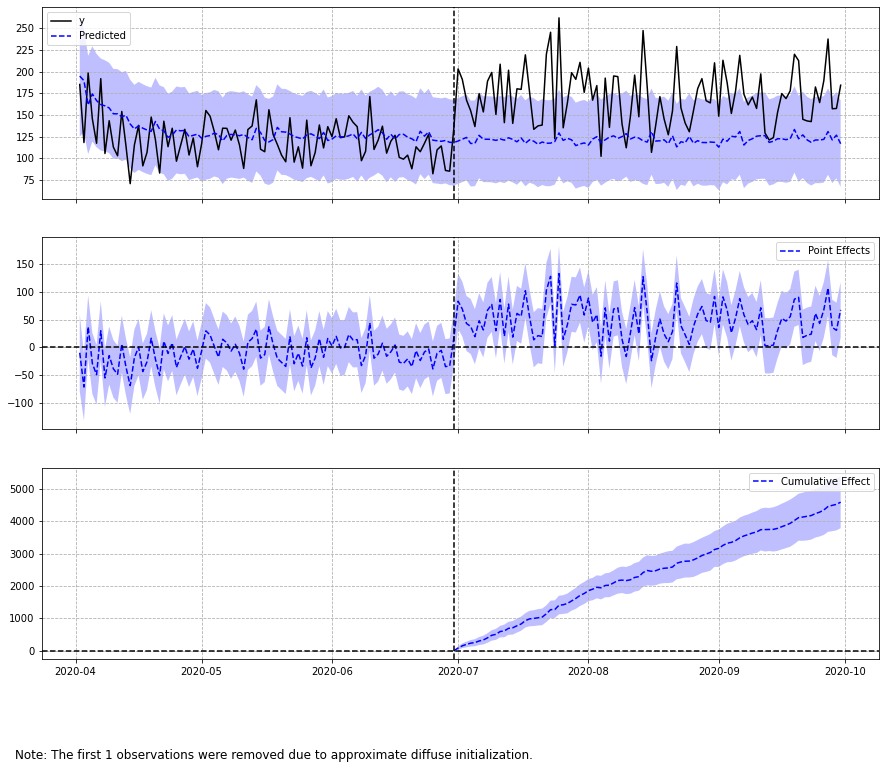

In [18]:
causal_impact_analysis.plot()

# Extracting summary statistics and report

In [19]:
print(causal_impact_analysis.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    171.33             15762.67
Prediction (s.d.)         121.42 (4.45)      11170.19 (409.28)
95% CI                    [112.73, 130.16]   [10370.7, 11975.05]

Absolute effect (s.d.)    49.92 (4.45)       4592.48 (409.28)
95% CI                    [41.17, 58.61]     [3787.62, 5391.97]

Relative effect (s.d.)    41.11% (3.66%)     41.11% (3.66%)
95% CI                    [33.91%, 48.27%]   [33.91%, 48.27%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


In [20]:
print(causal_impact_analysis.summary("report"))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 171.33. By contrast, in the absence of an
intervention, we would have expected an average response of 121.42.
The 95% interval of this counterfactual prediction is [112.73, 130.16].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 49.92 with a 95% interval of
[41.17, 58.61]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 15762.67.
By contrast, had the intervention not taken place, we would have expected
a sum of 11170.19. The 95% interval of this prediction is [10370.7, 11975.05].


The above results are given in terms of absolute numbers. In relative
terms, the resp

In [21]:
## pickling the model
pickle.dump(causal_impact_analysis, open('causal_impact_analysis.pkl', 'wb'))